In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

print(tf.__version__)

2021-11-03 05:04:19.971432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

2021-11-03 05:04:21.859424: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-03 05:04:21.860651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-03 05:04:21.909739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 05:04:21.910173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 05:04:21.910233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:

CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]

##  Dataset Preparation

Split the dataset ....

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch the dataset
#https://www.tensorflow.org/tutorials/load_data/images
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds



def getFMDdataset(image_dir,batch_size=8,img_size=(224,224)):
    CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="training",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory( image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    train_dataset=configure_for_performance(train_dataset,batch_size)
    val_dataset=configure_for_performance(val_dataset,batch_size)

    return train_dataset,val_dataset

In [5]:

train_dataset,val_dataset= getFMDdataset("../dataset/FMD/image",8,(224,224))

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


2021-11-03 05:04:24.267885: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 05:04:24.402333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 05:04:24.402642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 05:04:24.402692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negat

2021-11-03 05:04:25.048093: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 05:04:25.066413: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


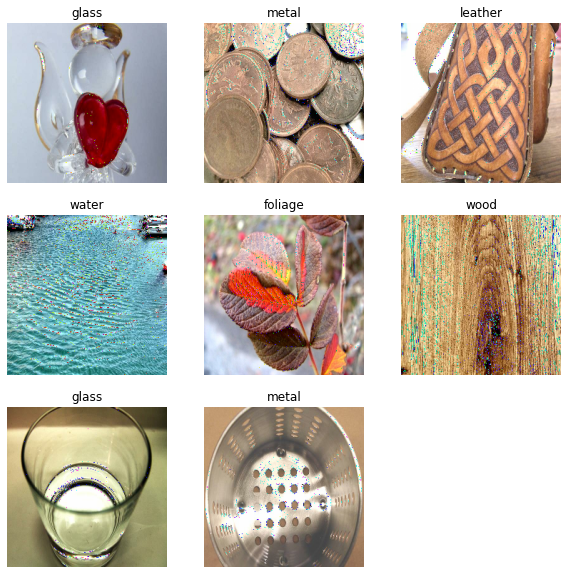

In [6]:
#visualize the dataset to ensure correctness
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(batch_size):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model


In [104]:
 data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(.3)
 ])


def resnet50():
    base_model=tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet')
    base_model.trainable=False
    base_model.training=False

    regularizer=tf.keras.regularizers.l2(0.0001)
    for layer in base_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input((224, 224, 3)),
        data_augmentation,
        tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, name='preprocessing', input_shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(10,activation="softmax")    
    ])
#     model.summary()
    return model

model=resnet50()

In [105]:
LEARNING_RATE=0.001
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
____________________________________

In [96]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/resnet_normal_aug.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [97]:
EPOCHS=30

history = model.fit(
        train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper],
        use_multiprocessing=True,
        workers=4
)

Epoch 1/30
100/100 [==============================] - 20s 24ms/step - loss: 2.3027 - accuracy: 0.1870 - val_loss: 1.2577 - val_accuracy: 0.6850
Epoch 2/30
100/100 [==============================] - 2s 18ms/step - loss: 1.2744 - accuracy: 0.6050 - val_loss: 0.9533 - val_accuracy: 0.7250
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.9771 - accuracy: 0.6992 - val_loss: 0.8092 - val_accuracy: 0.7950
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.8469 - accuracy: 0.7360 - val_loss: 0.7760 - val_accuracy: 0.8000
Epoch 5/30
100/100 [==============================] - 2s 19ms/step - loss: 0.7515 - accuracy: 0.7872 - val_loss: 0.7177 - val_accuracy: 0.7950
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.7342 - accuracy: 0.7558 - val_loss: 0.7067 - val_accuracy: 0.7800
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.6864 - accuracy: 0.7749 - val_loss: 0.6848 - val_accuracy: 0.800

## Visualize resul

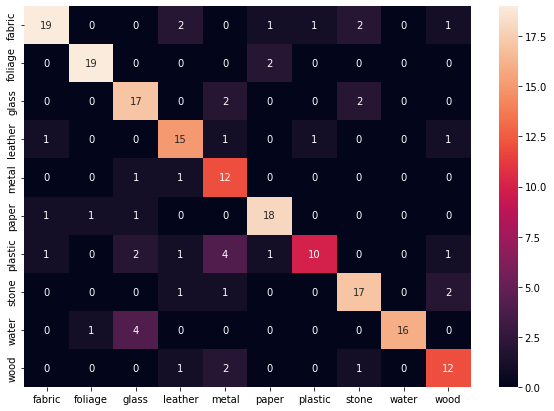

In [50]:

def plot_confusion_matrix(model,classes):
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_dataset:
      predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)],axis=None)
      labels = np.concatenate([labels, y],axis=None)

    confusion_matrix= tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_cm = pd.DataFrame(confusion_matrix, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
plot_confusion_matrix(model,CLASSES)

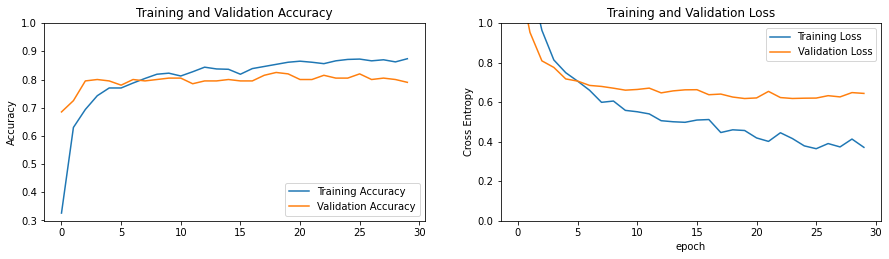

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning 

In [102]:
model.layers[2].trainable=True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers[2].layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[2].layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE/20),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Number of layers in the base model:  237
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                12810     
Total params: 4,062,381
Trainable params: 2,008,170
Non-trainable params: 2,05

In [103]:
fine_tune_epochs = 30
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset)

Epoch 30/59
100/100 [==============================] - 13s 30ms/step - loss: 1.0124 - accuracy: 0.6840 - val_loss: 0.6951 - val_accuracy: 0.7850
Epoch 31/59
100/100 [==============================] - 2s 19ms/step - loss: 0.8178 - accuracy: 0.7099 - val_loss: 0.7315 - val_accuracy: 0.7850
Epoch 32/59
100/100 [==============================] - 2s 19ms/step - loss: 0.7700 - accuracy: 0.7403 - val_loss: 0.7321 - val_accuracy: 0.7750
Epoch 33/59
100/100 [==============================] - 2s 18ms/step - loss: 0.6997 - accuracy: 0.7722 - val_loss: 0.7370 - val_accuracy: 0.7700
Epoch 34/59
100/100 [==============================] - 2s 18ms/step - loss: 0.5881 - accuracy: 0.7959 - val_loss: 0.7191 - val_accuracy: 0.7850
Epoch 35/59
100/100 [==============================] - 2s 18ms/step - loss: 0.5484 - accuracy: 0.8225 - val_loss: 0.7175 - val_accuracy: 0.7800
Epoch 36/59
100/100 [==============================] - 2s 17ms/step - loss: 0.4925 - accuracy: 0.8418 - val_loss: 0.7162 - val_accuracy

In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

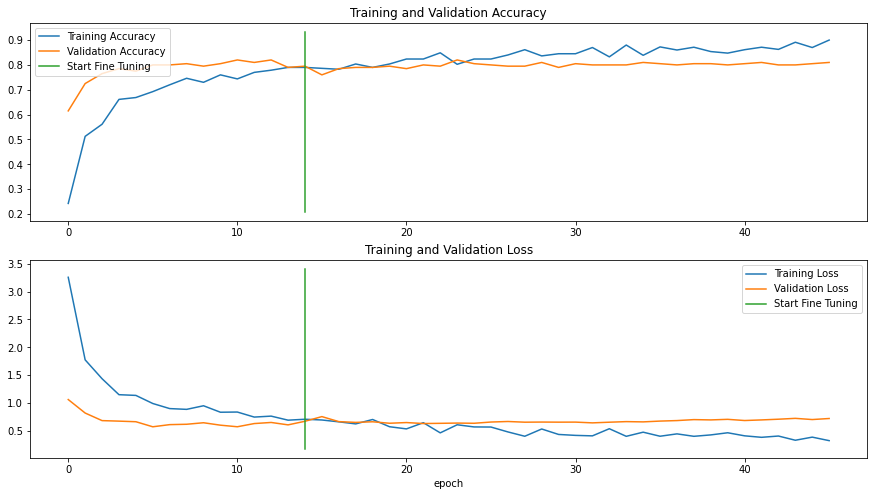

In [64]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()